In [1]:
!pip install SentencePiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importing all required packages and ignore warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import transformers
from tensorflow.keras.optimizers import Adam, SGD
from IPython.display import Markdown, display
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
from pathlib import Path
pd.options.display.max_colwidth = 100

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading all the cleaned data

## XLNET

In [5]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train1.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test1.csv')

In [6]:
train.columns = ['class','text']
test.columns = ['class','text']
train.head()


,class,text
0,1,work life balance treat employee slaves set un realistic goal achieve either work hrs make alot ...
1,0,good work environment culture teammates supportive management transparent huge cafeteria gaming ...
2,0,huawei chinese company huge politics company indian manegement indian manger talwe chatate hai c...
3,0,job secured even layoffs companies huawei layoff people shortage manpower within company high at...
4,0,work wise would give full potential proper tools career growth opportunities job risk learning d...


In [7]:
test.head()

,class,text
0,0,career growth innovation work life balance training job security salary travel politics etc
1,0,team work remote location
2,0,job security value staff
3,0,project understanding new technology box thinking make possible attitude new learning nature peo...
4,0,good working environment much working hours issue


In [8]:
from transformers import TFXLNetModel, XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)


In [9]:
def xlnet_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [10]:
train.shape

(350006, 2)

In [11]:
test.shape

(87505, 2)

In [12]:
train_input_ids,train_attention_masks = xlnet_encode(train[:350000],120)
test_input_ids,test_attention_masks = xlnet_encode(test[:87000],120)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [13]:
xlnet_model = 'xlnet-base-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

In [14]:
def create_model_xlnet(xlnet_model):
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    
    xlnet = TFXLNetModel.from_pretrained(xlnet_model)
    xlnet_encodings = xlnet(word_inputs)[0]

    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
     
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [15]:
xlnet = create_model_xlnet(xlnet_model)
xlnet.summary()

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 120)]             0         
                                                                 
 tfxl_net_model (TFXLNetMode  TFXLNetModelOutput(last_  116718336
 l)                          hidden_state=(None, 120,            
                              768),                              
                              mems=((120, None, 768),            
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),                  
                              (120, None, 768),              

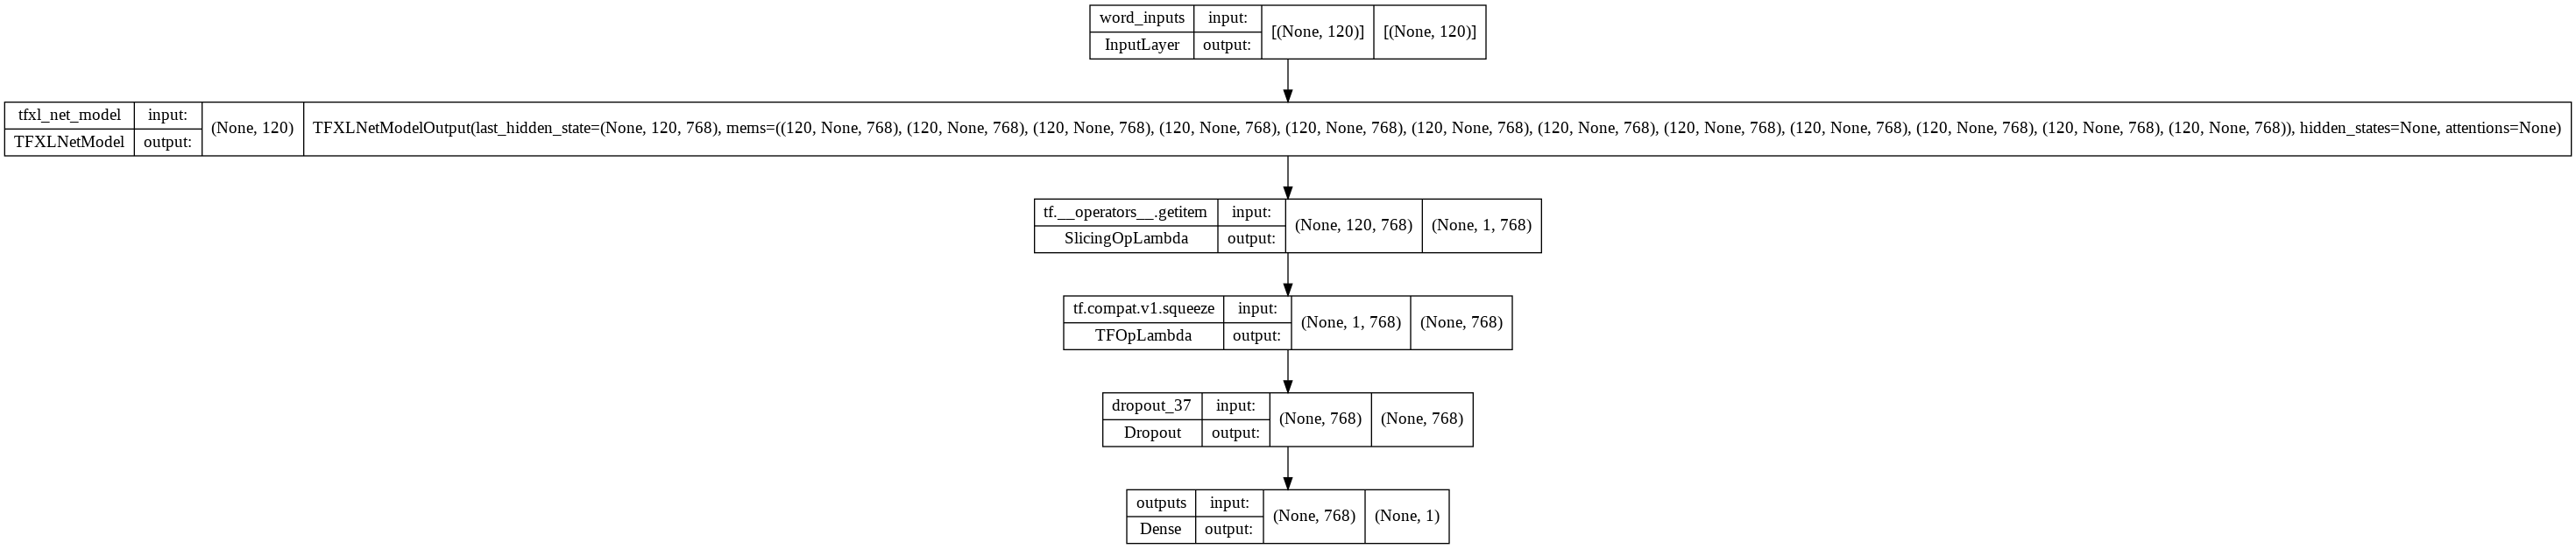

In [16]:
plot_model(xlnet, to_file='model_xl.png', expand_nested=True, show_shapes=True)

In [17]:
dummy = train[:350000]
targets = dummy['class'].values

dummy2 = test[:87000]
targets_y = dummy2['class'].values

In [18]:
history_xl = xlnet.fit(train_input_ids,targets,validation_data=(test_input_ids,targets_y), epochs=4,batch_size=64)

Epoch 1/4


5469/5469 [==============================] - 12367s 2s/step - loss: 0.1114 - accuracy: 0.9595 - val_loss: 0.0812 - val_accuracy: 0.9678
Epoch 2/4
5469/5469 [==============================] - 12364s 2s/step - loss: 0.0779 - accuracy: 0.9700 - val_loss: 0.0762 - val_accuracy: 0.9737
Epoch 3/4
5469/5469 [==============================] - 12359s 2s/step - loss: 0.0621 - accuracy: 0.9755 - val_loss: 0.0786 - val_accuracy: 0.9754
Epoch 4/4
5469/5469 [==============================] - 12362s 2s/step - loss: 0.0488 - accuracy: 0.9807 - val_loss: 0.0728 - val_accuracy: 0.9740


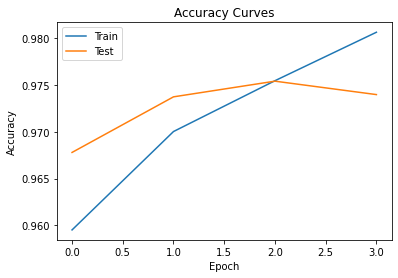

In [19]:
plt.plot(history_xl.history['accuracy'])
plt.plot(history_xl.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


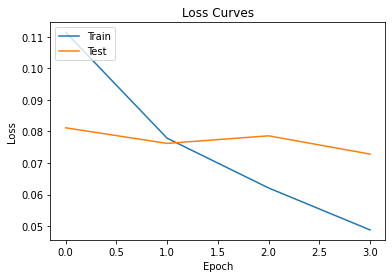

In [20]:
plt.plot(history_xl.history['loss'])
plt.plot(history_xl.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, brier_score_loss

In [31]:
model_results = pd.DataFrame()
def get_model_metrics(y_test, y_pred, model_name):
    display(Markdown("------ "))
    display(Markdown("### " + model_name + " Model Metrics Summary : "))
    cm = confusion_matrix(y_test,y_pred)
    display(Markdown("#### Confusion Matrix : "))

    display(cm)
    accuracy = round(accuracy_score(y_test,y_pred), 2)
    precision = round(precision_score(y_test,y_pred), 2)
    recall = round(recall_score(y_test,y_pred), 2)
    auc = round(roc_auc_score(y_test,y_pred), 2)
    f1 = round(f1_score(y_test,y_pred), 2)
    brier_loss = round(brier_score_loss(y_test,y_pred), 4)
    
    data = [[model_name, accuracy, precision, recall, auc, f1, brier_loss]] 
    df = pd.DataFrame(data, columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'AUC', 'F1', 'Brier Loss'])
    global model_results 
    model_results = model_results.append(df, ignore_index=True)
    return df

In [23]:
X_test = dummy2.drop(["class"], axis=1)

In [34]:
y_test = dummy2["class"]

In [35]:
y_pred = xlnet.predict(test_input_ids)

In [36]:
y_pred_bool=np.argmax(y_pred,axis=1)

In [37]:
print(confusion_matrix(y_test,y_pred_bool))

[[71165     0]
 [15835     0]]


In [38]:
get_model_metrics(y_test, y_pred_bool, 'XLNet Classification')

------ 

### XLNet Classification Model Metrics Summary : 

#### Confusion Matrix : 

array([[71165,     0],
       [15835,     0]])

,Model Name,Accuracy,Precision,Recall,AUC,F1,Brier Loss
0,XLNet Classification,0.82,0.0,0.0,0.5,0.0,0.182


In [40]:
print(classification_report(y_test,y_pred_bool))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     71165
           1       0.00      0.00      0.00     15835

    accuracy                           0.82     87000
   macro avg       0.41      0.50      0.45     87000
weighted avg       0.67      0.82      0.74     87000



In [41]:
# Print f1, precision, and recall scores
print(precision_score(y_test, y_pred_bool , average="macro"))
print(recall_score(y_test, y_pred_bool , average="macro"))
print(f1_score(y_test, y_pred_bool , average="macro"))

0.4089942528735632
0.5
0.4499415167704612


In [42]:
auc = round(roc_auc_score(y_test,y_pred), 2)
auc

0.99

<Figure size 432x288 with 0 Axes>

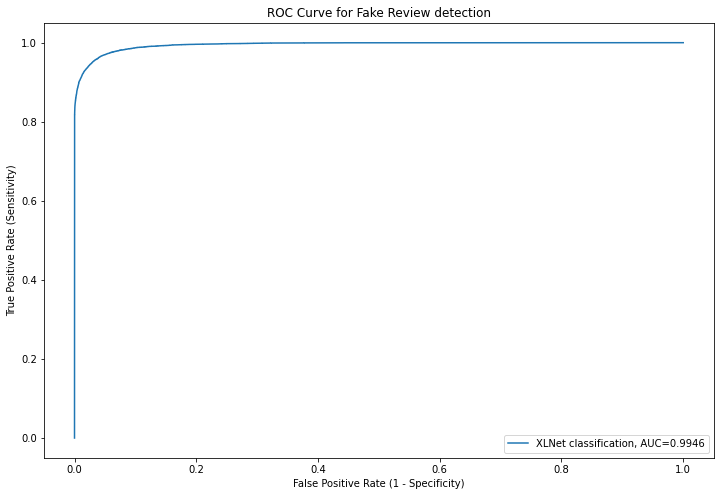

In [44]:
#set up plotting area
plt.figure(0).clf()
plt.figure(figsize=(12,8))
plt.title('ROC Curve for Fake Review detection')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

#plot ROC curve for XLNet classification model
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XLNet classification, AUC="+str(auc))
plt.legend()